In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models._utils import IntermediateLayerGetter
from torchsummary import summary

# Configs
NUM_CLASSES = 3  # Including background
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 65

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_PATH = r"G:\downloads\LiTS_processed_3_4\LiTS_processed_3_4\tri_class\images"
MASK_PATH = r"G:\downloads\LiTS_processed_3_4\LiTS_processed_3_4\tri_class\masks"

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.4),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])


C:\Users\my pc\.conda\envs\pt_container\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

class LiverDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = np.array(Image.open(image_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE)))
        mask = np.array(Image.open(mask_path).resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].long()
        else:
            image = transforms.ToTensor()(image)
            mask = torch.tensor(mask).long()

        return image, mask


In [4]:
# Full dataset
full_dataset = LiverDataset(IMG_PATH, MASK_PATH)

# Split
train_len = int(0.7 * len(full_dataset))
val_len = int(0.15 * len(full_dataset))
test_len = len(full_dataset) - train_len - val_len

train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])

# Apply augmentations to datasets
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

# Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GhostModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, ratio=2):
        super(GhostModule, self).__init__()
        init_channels = int(out_channels / ratio)
        new_channels = out_channels - init_channels

        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels, init_channels, kernel_size=kernel_size, padding=kernel_size // 2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True)
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, kernel_size=3, stride=1, padding=1, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        return torch.cat([x1, x2], dim=1)


class HalfUNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, out_channels=3):
        super(HalfUNet, self).__init__()

        # Encoder
        self.enc1 = GhostModule(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = GhostModule(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = GhostModule(base_channels * 2, base_channels * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = GhostModule(base_channels * 4, base_channels * 8)

        # Decoder
        self.up1 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)

        # Align encoder feature channels
        self.align1 = nn.Conv2d(base_channels, base_channels, kernel_size=1)
        self.align2 = nn.Conv2d(base_channels * 2, base_channels, kernel_size=1)
        self.align3 = nn.Conv2d(base_channels * 4, base_channels, kernel_size=1)

        # Final prediction layer
        self.final = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)

        u1 = self.up1(e4)
        u2 = self.up2(u1)
        u3 = self.up3(u2)

        # Resize encoder features to match u3
        e1 = F.interpolate(e1, size=u3.shape[2:])
        e2 = F.interpolate(e2, size=u3.shape[2:])
        e3 = F.interpolate(e3, size=u3.shape[2:])

        # Align channels
        e1 = self.align1(e1)
        e2 = self.align2(e2)
        e3 = self.align3(e3)

        # Full-scale fusion using addition
        out = e1 + e2 + e3 + u3

        return self.final(out)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HalfUNet(in_channels=3, out_channels=3).to(device)


summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]              96
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
       GhostModule-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]           4,096
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]             576
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [6]:
# Loss Functions
ce_loss = nn.CrossEntropyLoss()

def dice_loss(pred, target, num_classes=3):
    pred = F.softmax(pred, dim=1)
    loss = 0.0
    for cls in range(1, num_classes):  # skip background class
        pred_cls = pred[:, cls]
        target_cls = (target == cls).float()
        inter = (pred_cls * target_cls).sum(dim=(1, 2))
        union = pred_cls.sum(dim=(1, 2)) + target_cls.sum(dim=(1, 2))
        dice = (2 * inter + 1e-6) / (union + 1e-6)
        loss += 1 - dice.mean()
    return loss / (num_classes - 1)

# Combined Loss
def combined_loss(pred, target, alpha=0.5):
    return alpha * ce_loss(pred, target) + (1 - alpha) * dice_loss(pred, target)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Dice Score for evaluation
def dice_score(pred, target, num_classes=3):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    dice = []
    for cls in range(1, num_classes):  # Exclude background class
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        inter = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice.append(((2 * inter + 1e-6) / (union + 1e-6)).item())
    return dice


In [7]:

# Training Loop
train_losses, val_dices = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # Validation Dice
    model.eval()
    dice_total = np.zeros(NUM_CLASSES - 1)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            dice = dice_score(outputs, masks, NUM_CLASSES)
            dice_total += np.array(dice)
    val_dices.append((dice_total / len(val_loader)).tolist())

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Dice: {[round(d, 4) for d in val_dices[-1]]}")


Epoch 1/65, Loss: 0.5495, Dice: [0.7546, 0.0]
Epoch 2/65, Loss: 0.3713, Dice: [0.8186, 0.0]
Epoch 3/65, Loss: 0.3494, Dice: [0.8428, 0.033]
Epoch 4/65, Loss: 0.3321, Dice: [0.8583, 0.2064]
Epoch 5/65, Loss: 0.3127, Dice: [0.86, 0.2736]
Epoch 6/65, Loss: 0.2969, Dice: [0.8749, 0.3371]
Epoch 7/65, Loss: 0.2848, Dice: [0.8776, 0.3835]
Epoch 8/65, Loss: 0.2692, Dice: [0.8813, 0.3906]
Epoch 9/65, Loss: 0.2555, Dice: [0.8762, 0.3986]
Epoch 10/65, Loss: 0.2445, Dice: [0.8862, 0.4175]
Epoch 11/65, Loss: 0.2331, Dice: [0.8937, 0.4632]
Epoch 12/65, Loss: 0.2260, Dice: [0.8899, 0.4605]
Epoch 13/65, Loss: 0.2183, Dice: [0.899, 0.4933]
Epoch 14/65, Loss: 0.2140, Dice: [0.8928, 0.5084]
Epoch 15/65, Loss: 0.2133, Dice: [0.8966, 0.5031]
Epoch 16/65, Loss: 0.2033, Dice: [0.8982, 0.5007]
Epoch 17/65, Loss: 0.1953, Dice: [0.9042, 0.5457]
Epoch 18/65, Loss: 0.1943, Dice: [0.905, 0.5546]
Epoch 19/65, Loss: 0.1830, Dice: [0.9083, 0.5576]
Epoch 20/65, Loss: 0.1782, Dice: [0.9057, 0.5715]
Epoch 21/65, Loss: 0

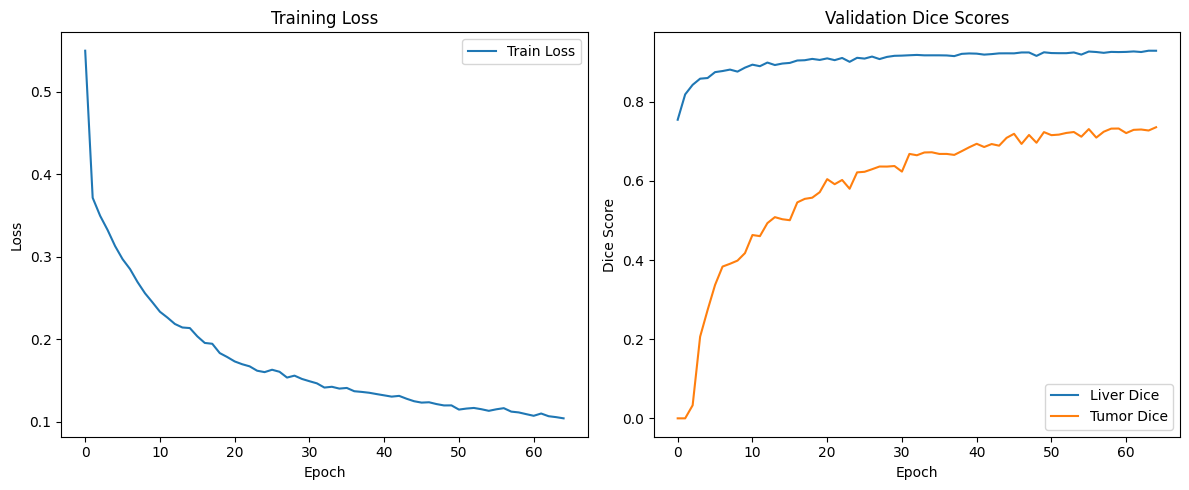


Final Test Dice (Liver, Tumor): [0.9324, 0.747]


In [8]:

# Plot graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
val_dices_np = np.array(val_dices)
plt.plot(val_dices_np[:, 0], label="Liver Dice")
plt.plot(val_dices_np[:, 1], label="Tumor Dice")
plt.title("Validation Dice Scores")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.tight_layout()
plt.show()

# Test Prediction
model.eval()
test_dice_total = np.zeros(NUM_CLASSES - 1)
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_dice_total += np.array(dice_score(outputs, masks, NUM_CLASSES))
final_test_dice = (test_dice_total / len(test_loader)).tolist()
print(f"\nFinal Test Dice (Liver, Tumor): {[round(d, 4) for d in final_test_dice]}")

In [12]:
torch.save(model.state_dict(), 'half_unet_weights.pth')

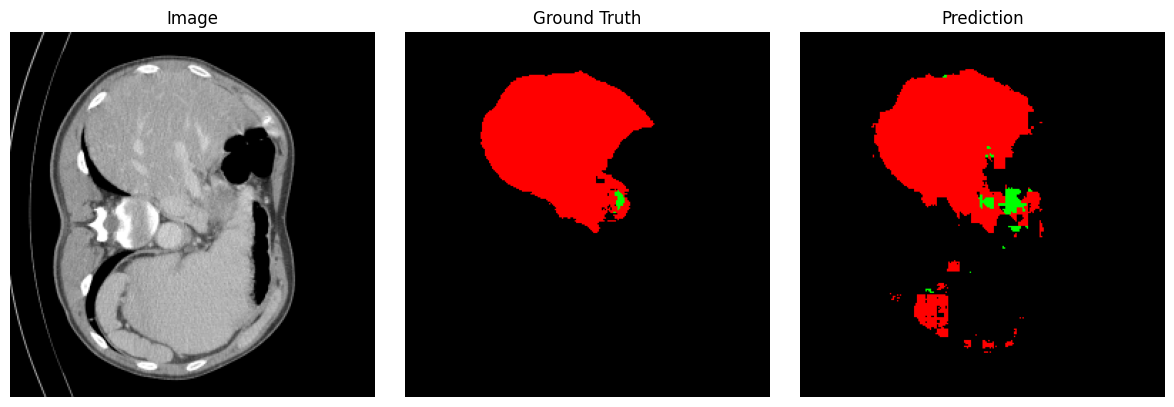

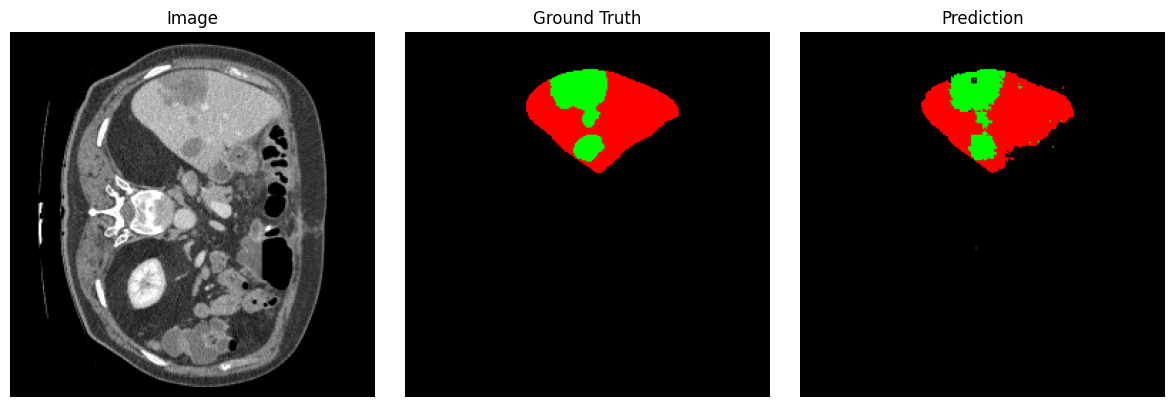

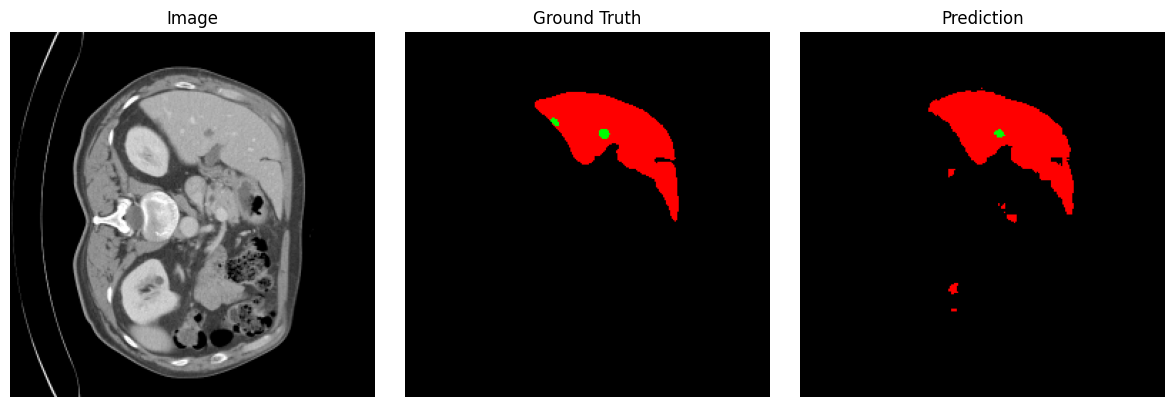

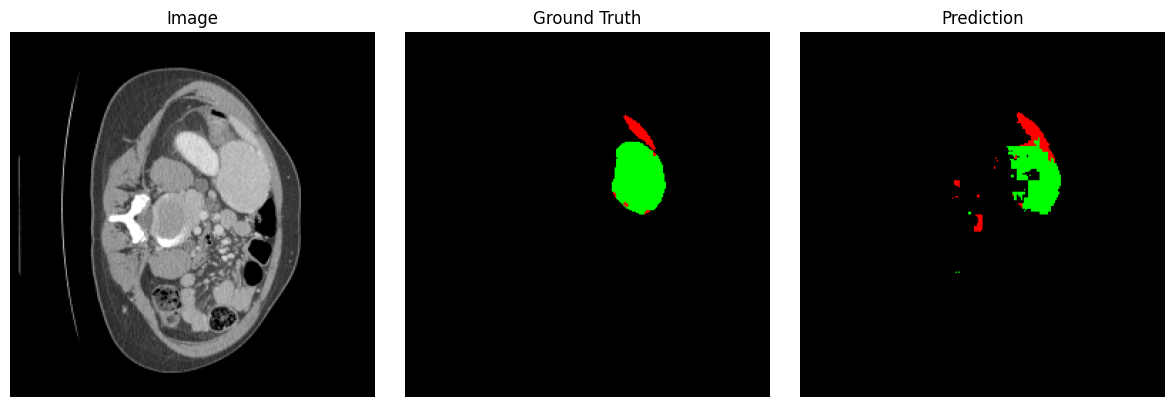

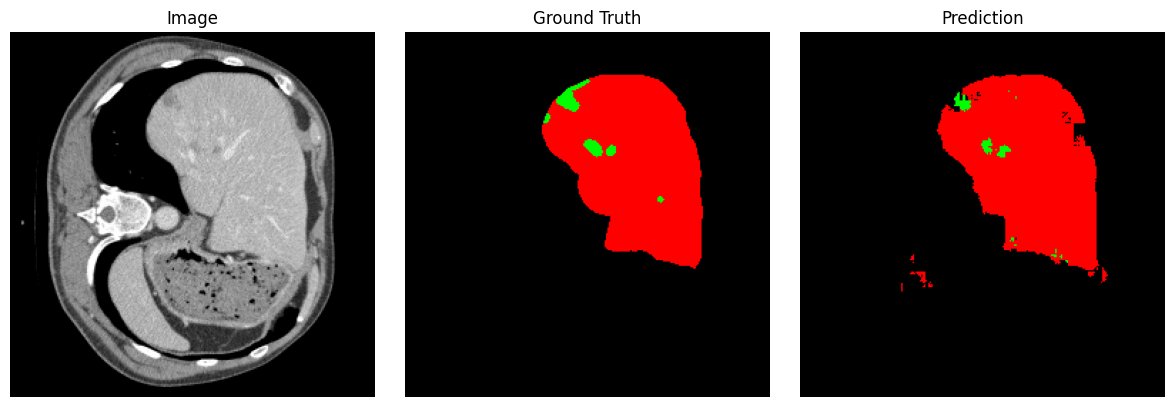

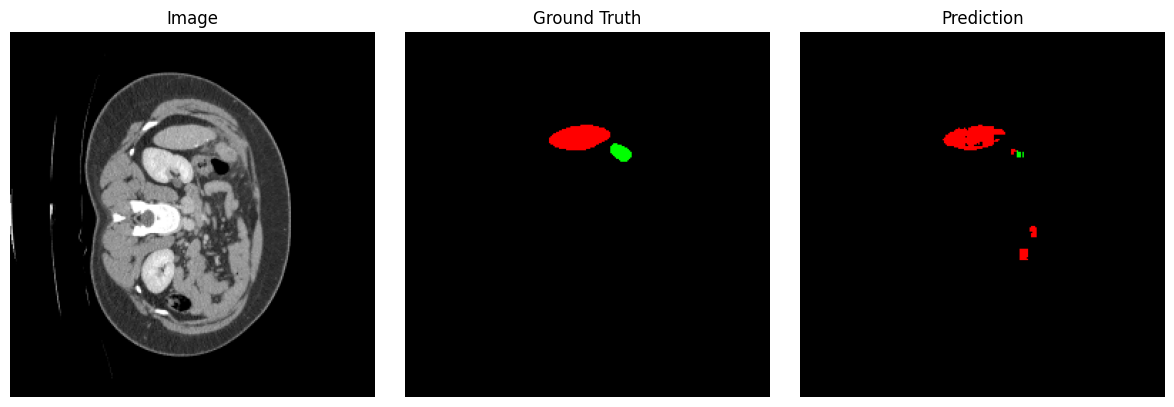

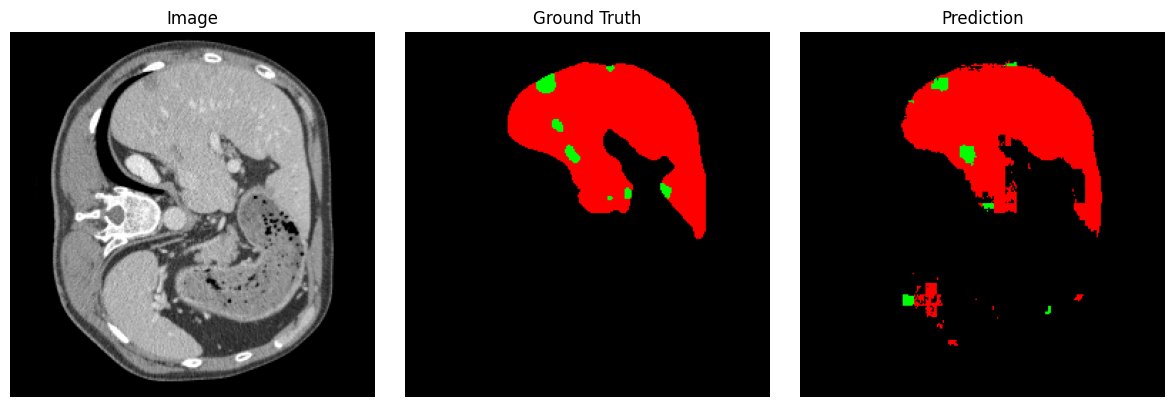

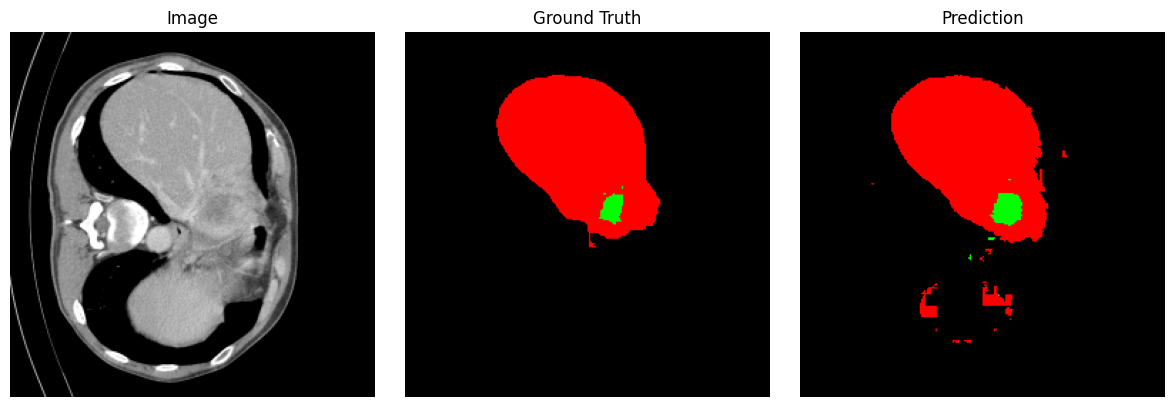

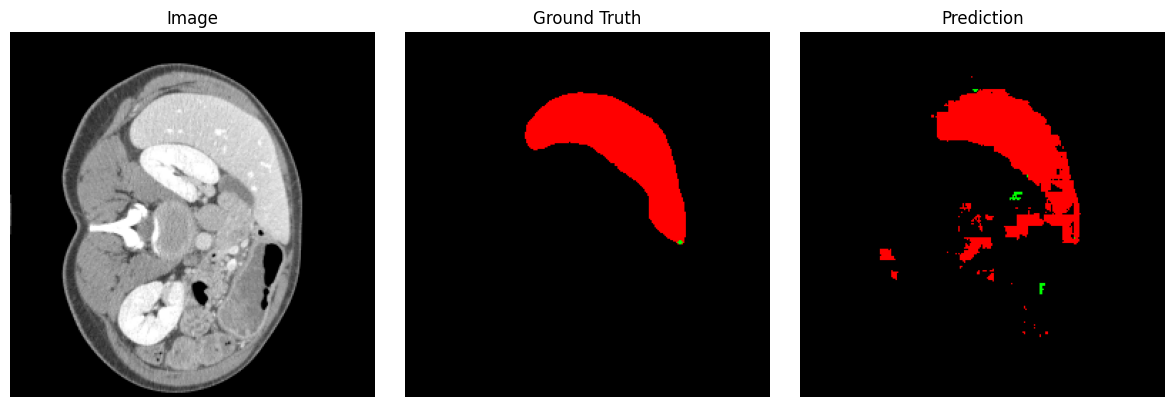

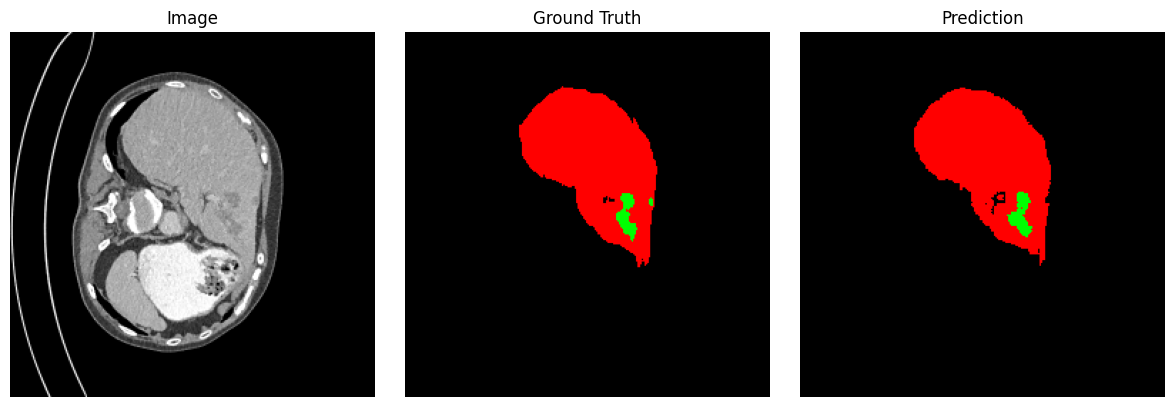

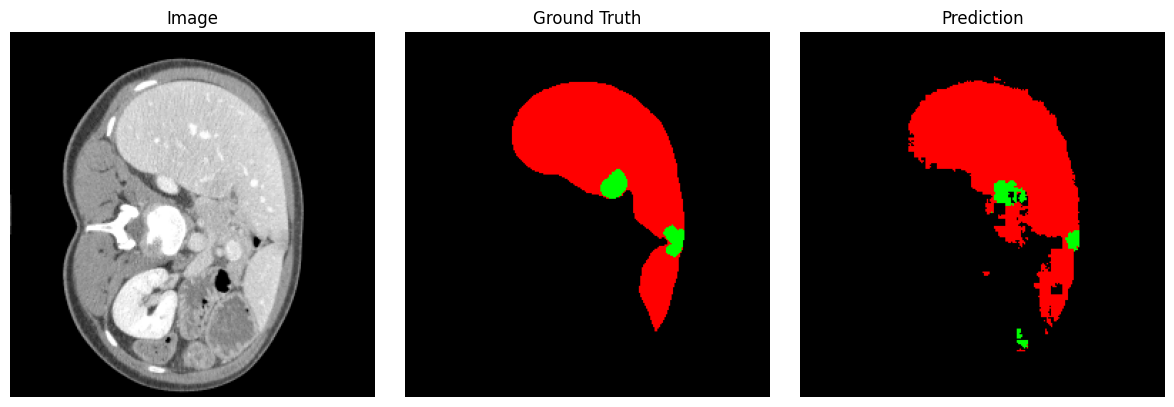

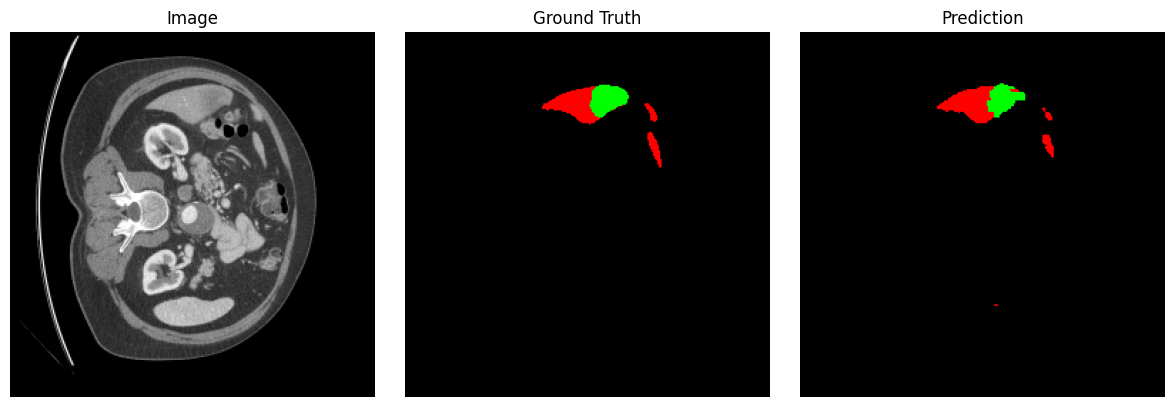

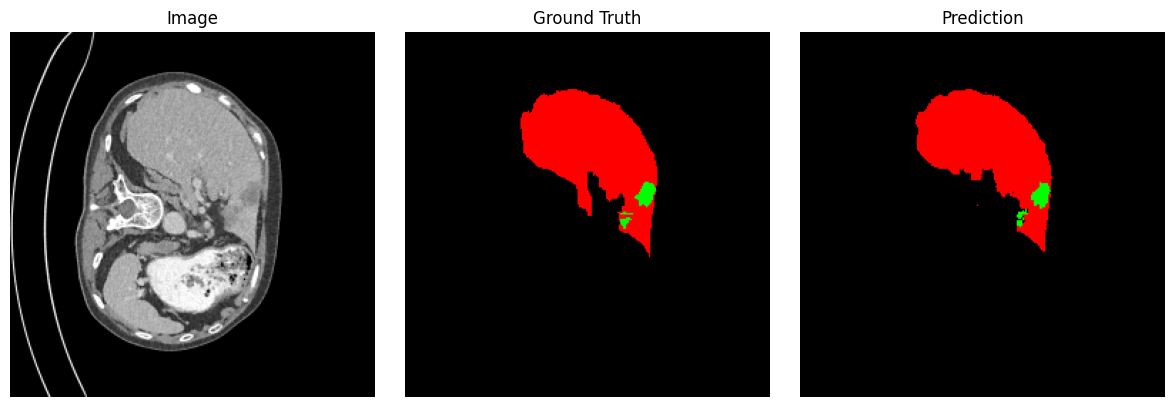

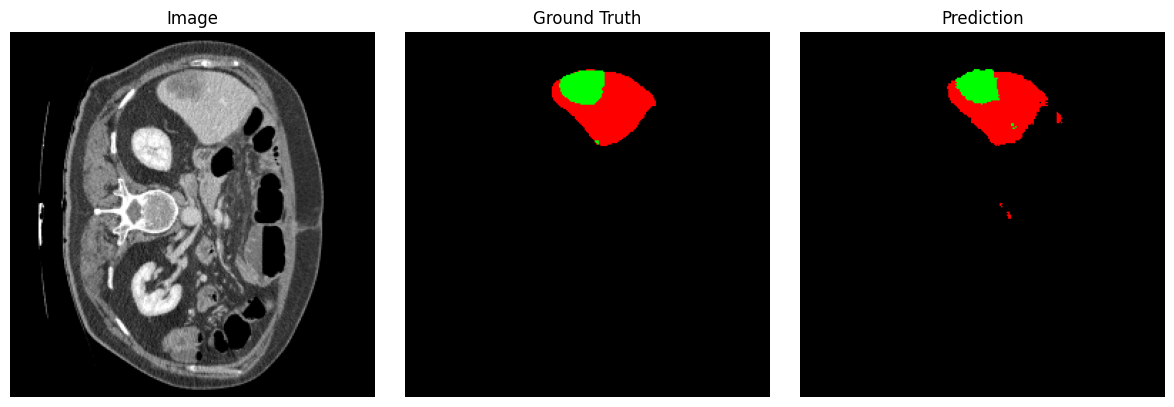

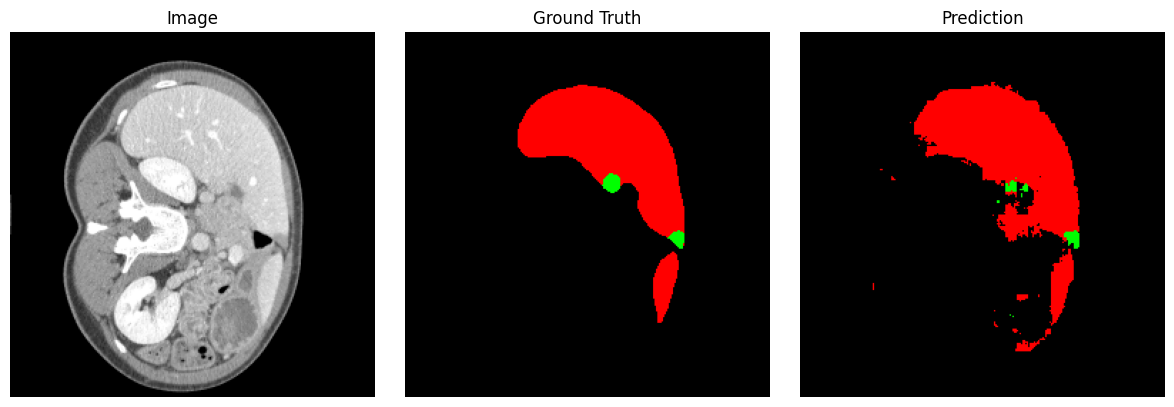

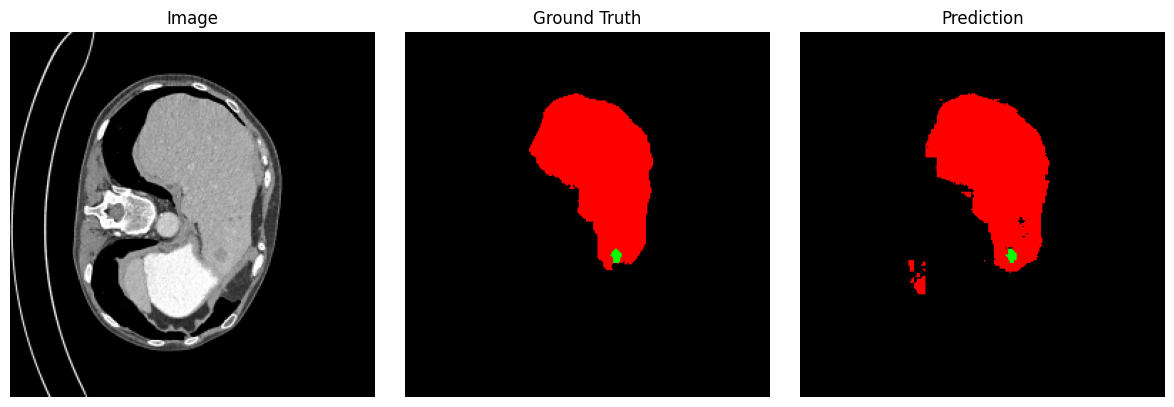

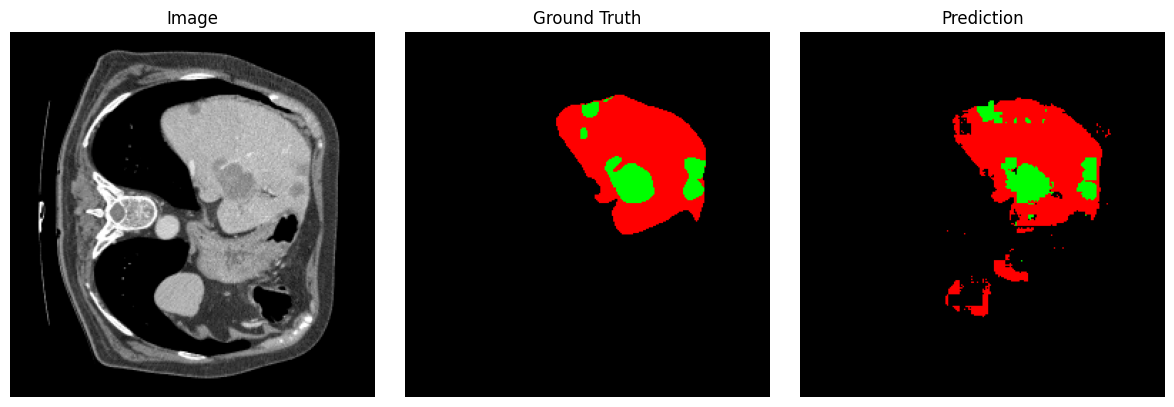

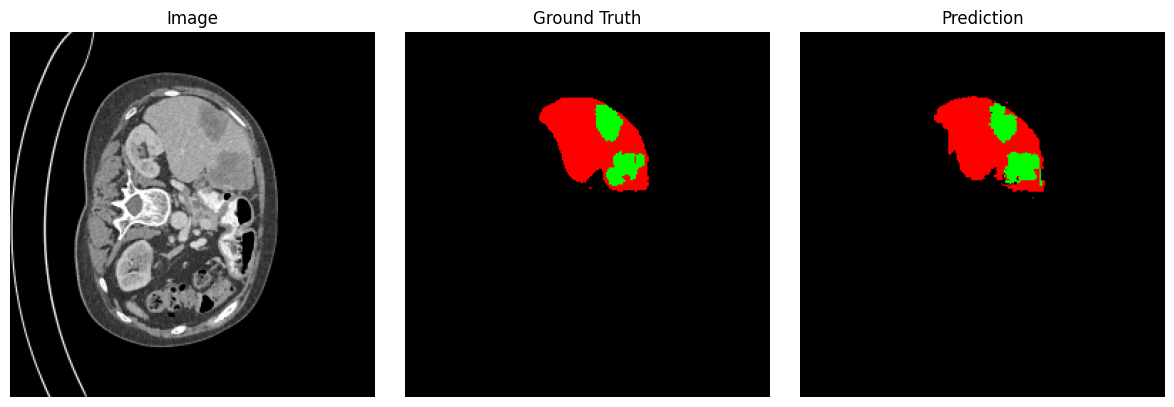

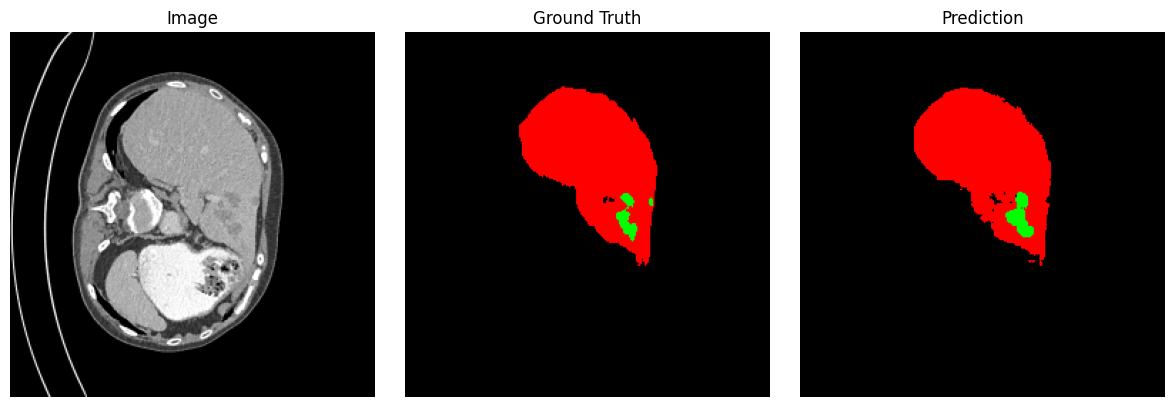

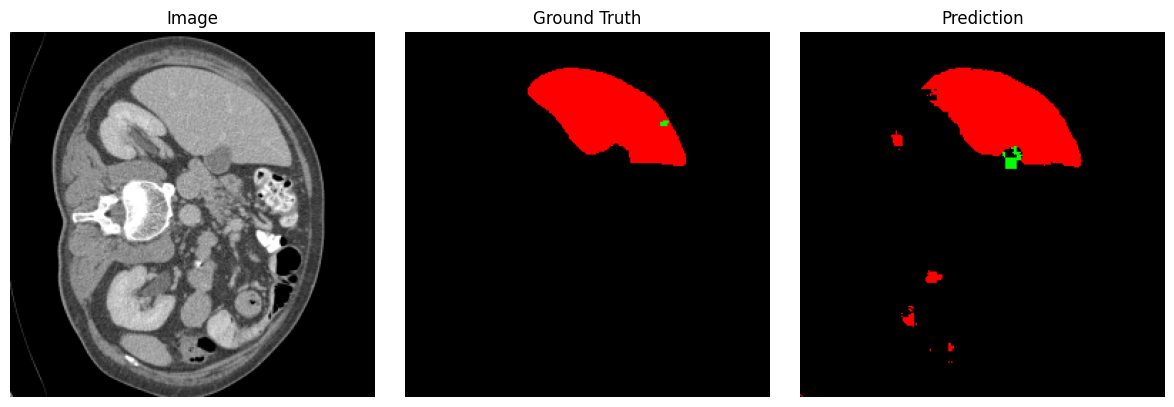

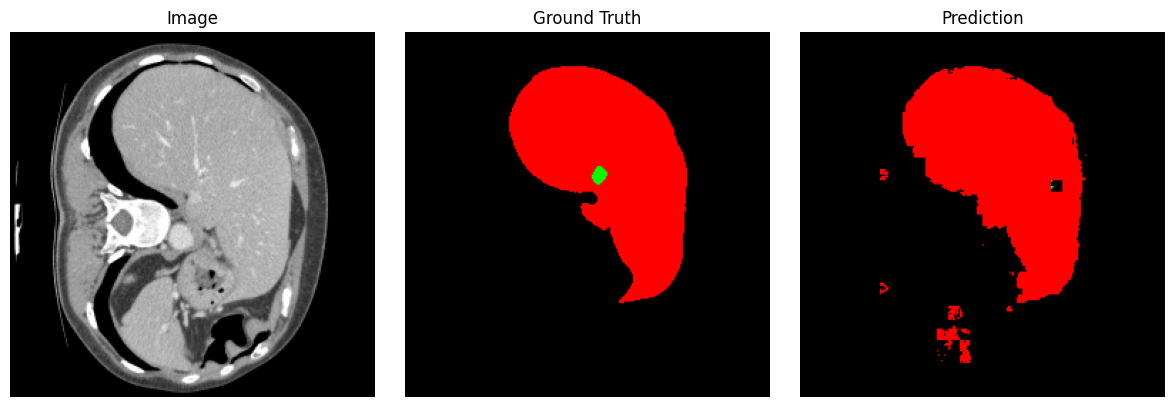

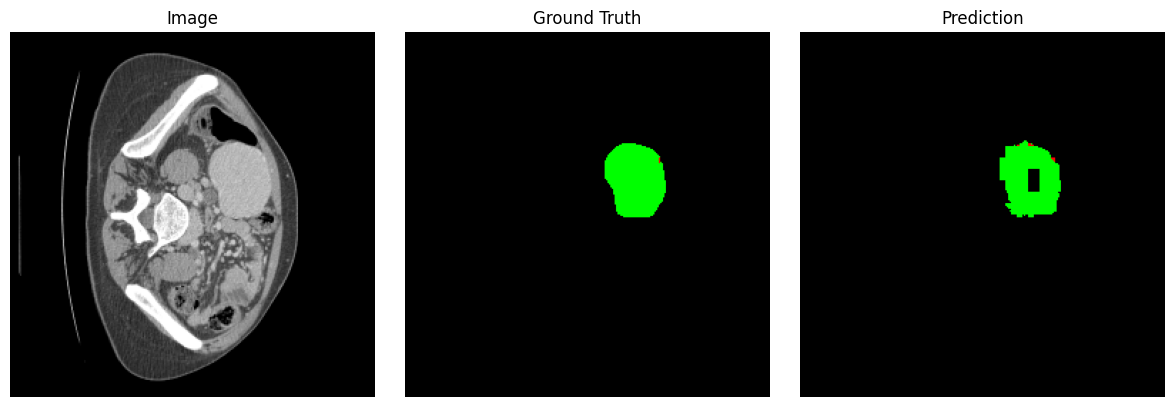

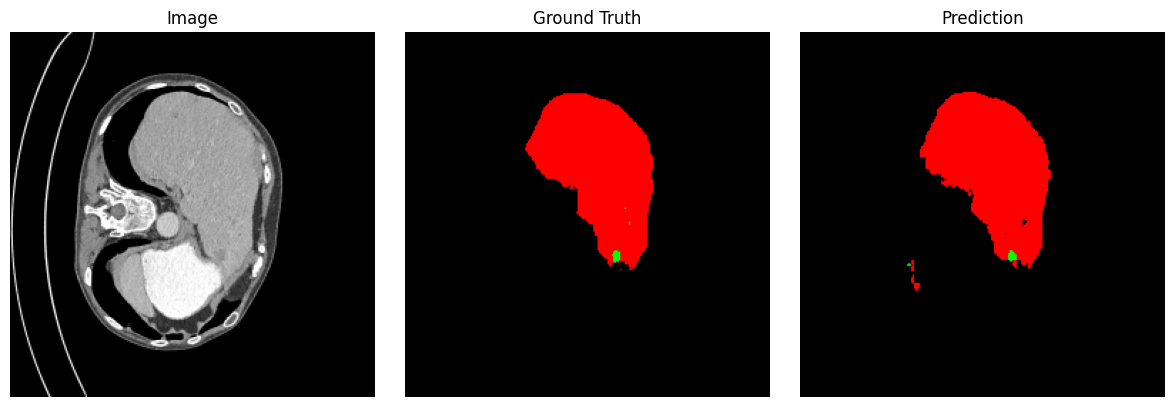

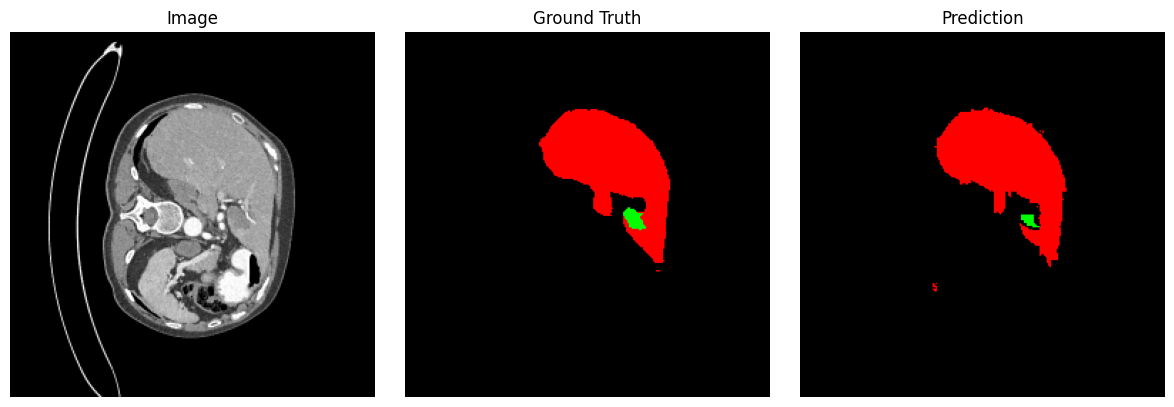

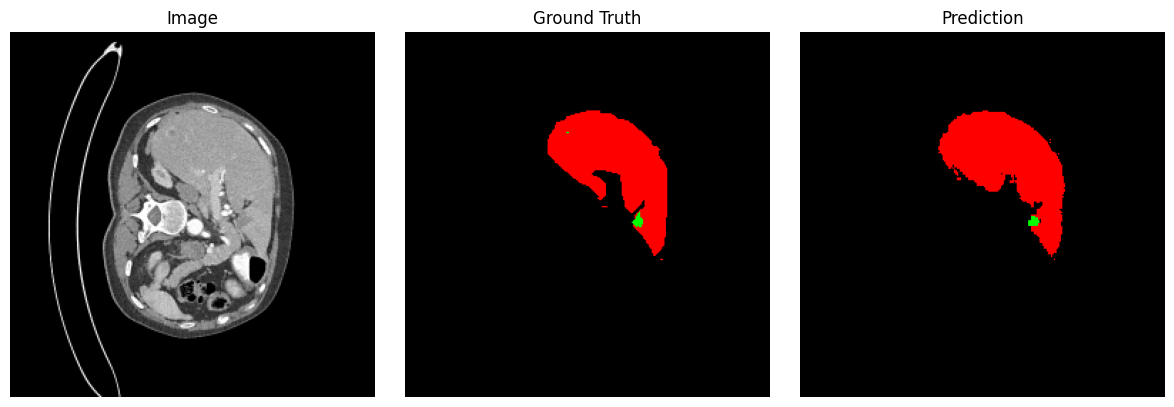

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a list of RGB tuples or hex color codes
class_colors = [
    (0, 0, 0),       # class 0 - black (usually background)
    (255, 0, 0),     # class 1 - red
    (0, 255, 0),     # class 2 - green
    # Add more if you have more classes
]

# Normalize to [0,1] for matplotlib
class_colors_norm = [(r/255, g/255, b/255) for r, g, b in class_colors]

# Create a colormap
cmap = mcolors.ListedColormap(class_colors_norm)

def visualize_prediction(model, dataloader, device, num_samples=25, num_classes=3):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu()
            images = images.cpu()
            masks = masks.cpu()

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    return
                
                img = images[i].permute(1, 2, 0).numpy()
                mask = masks[i].numpy()
                pred = preds[i].numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img)
                axs[0].set_title('Image')
                axs[1].imshow(mask, cmap=cmap, vmin=0, vmax=num_classes - 1)
                axs[1].set_title('Ground Truth')
                axs[2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes - 1)
                axs[2].set_title('Prediction')

                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                images_shown += 1
visualize_prediction(model, test_loader, device, num_samples=25, num_classes=3)

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:32<00:00,  2.23it/s]


Epoch 1/50, Loss: 0.3286, Dice: [0.7501, 0.0]
✅ Saved best model (Dice: 0.3750)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.12it/s]


Epoch 2/50, Loss: 0.1023, Dice: [0.8067, 0.0]
✅ Saved best model (Dice: 0.4034)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:18<00:00,  3.97it/s]


Epoch 3/50, Loss: 0.0868, Dice: [0.8319, 0.0]
✅ Saved best model (Dice: 0.4159)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.12it/s]


Epoch 4/50, Loss: 0.0796, Dice: [0.8361, 0.0]
✅ Saved best model (Dice: 0.4180)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.12it/s]


Epoch 5/50, Loss: 0.0742, Dice: [0.8448, 0.0]
✅ Saved best model (Dice: 0.4224)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.09it/s]


Epoch 6/50, Loss: 0.0710, Dice: [0.8514, 0.0]
✅ Saved best model (Dice: 0.4257)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:18<00:00,  3.99it/s]


Epoch 7/50, Loss: 0.0664, Dice: [0.8621, 0.0]
✅ Saved best model (Dice: 0.4310)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch 8/50, Loss: 0.0645, Dice: [0.8672, 0.0]
✅ Saved best model (Dice: 0.4336)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.09it/s]


Epoch 9/50, Loss: 0.0616, Dice: [0.8701, 0.0]
✅ Saved best model (Dice: 0.4351)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch 10/50, Loss: 0.0599, Dice: [0.8719, 0.0065]
✅ Saved best model (Dice: 0.4392)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.10it/s]


Epoch 11/50, Loss: 0.0576, Dice: [0.8739, 0.0151]
✅ Saved best model (Dice: 0.4445)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.05it/s]


Epoch 12/50, Loss: 0.0562, Dice: [0.8777, 0.0411]
✅ Saved best model (Dice: 0.4594)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.04it/s]


Epoch 13/50, Loss: 0.0542, Dice: [0.8843, 0.0696]
✅ Saved best model (Dice: 0.4770)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.04it/s]


Epoch 14/50, Loss: 0.0530, Dice: [0.8836, 0.0782]
✅ Saved best model (Dice: 0.4809)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 15/50, Loss: 0.0515, Dice: [0.885, 0.1663]
✅ Saved best model (Dice: 0.5257)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.10it/s]


Epoch 16/50, Loss: 0.0514, Dice: [0.8953, 0.2403]
✅ Saved best model (Dice: 0.5678)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.09it/s]


Epoch 17/50, Loss: 0.0494, Dice: [0.8873, 0.2038]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.09it/s]


Epoch 18/50, Loss: 0.0487, Dice: [0.8956, 0.2697]
✅ Saved best model (Dice: 0.5827)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch 19/50, Loss: 0.0464, Dice: [0.8994, 0.3508]
✅ Saved best model (Dice: 0.6251)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.09it/s]


Epoch 20/50, Loss: 0.0453, Dice: [0.8997, 0.3735]
✅ Saved best model (Dice: 0.6366)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 21/50, Loss: 0.0440, Dice: [0.895, 0.3554]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch 22/50, Loss: 0.0442, Dice: [0.8951, 0.3312]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.02it/s]


Epoch 23/50, Loss: 0.0426, Dice: [0.9027, 0.4493]
✅ Saved best model (Dice: 0.6760)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 24/50, Loss: 0.0419, Dice: [0.9061, 0.3567]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch 25/50, Loss: 0.0396, Dice: [0.9071, 0.472]
✅ Saved best model (Dice: 0.6896)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch 26/50, Loss: 0.0392, Dice: [0.9085, 0.477]
✅ Saved best model (Dice: 0.6927)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.09it/s]


Epoch 27/50, Loss: 0.0385, Dice: [0.9064, 0.4095]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch 28/50, Loss: 0.0378, Dice: [0.9066, 0.5276]
✅ Saved best model (Dice: 0.7171)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 29/50, Loss: 0.0376, Dice: [0.9081, 0.4487]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 30/50, Loss: 0.0358, Dice: [0.9096, 0.5121]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch 31/50, Loss: 0.0348, Dice: [0.915, 0.5058]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch 32/50, Loss: 0.0336, Dice: [0.9134, 0.5822]
✅ Saved best model (Dice: 0.7478)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 33/50, Loss: 0.0333, Dice: [0.9163, 0.5945]
✅ Saved best model (Dice: 0.7554)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.02it/s]


Epoch 34/50, Loss: 0.0317, Dice: [0.9172, 0.5485]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.09it/s]


Epoch 35/50, Loss: 0.0315, Dice: [0.9202, 0.6071]
✅ Saved best model (Dice: 0.7637)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:18<00:00,  3.98it/s]


Epoch 36/50, Loss: 0.0313, Dice: [0.9207, 0.6162]
✅ Saved best model (Dice: 0.7684)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch 37/50, Loss: 0.0315, Dice: [0.9179, 0.5931]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch 38/50, Loss: 0.0309, Dice: [0.9208, 0.6382]
✅ Saved best model (Dice: 0.7795)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 39/50, Loss: 0.0300, Dice: [0.923, 0.6302]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 40/50, Loss: 0.0289, Dice: [0.9233, 0.6218]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.04it/s]


Epoch 41/50, Loss: 0.0288, Dice: [0.9224, 0.5979]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.05it/s]


Epoch 42/50, Loss: 0.0283, Dice: [0.9244, 0.6622]
✅ Saved best model (Dice: 0.7933)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.06it/s]


Epoch 43/50, Loss: 0.0279, Dice: [0.9261, 0.6786]
✅ Saved best model (Dice: 0.8024)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.07it/s]


Epoch 44/50, Loss: 0.0269, Dice: [0.9252, 0.6408]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.02it/s]


Epoch 45/50, Loss: 0.0276, Dice: [0.9258, 0.6757]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 46/50, Loss: 0.0262, Dice: [0.928, 0.6625]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.04it/s]


Epoch 47/50, Loss: 0.0260, Dice: [0.9282, 0.6719]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.08it/s]


Epoch 48/50, Loss: 0.0255, Dice: [0.9307, 0.6922]
✅ Saved best model (Dice: 0.8114)


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.05it/s]


Epoch 49/50, Loss: 0.0265, Dice: [0.9222, 0.6848]


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00,  4.04it/s]


Epoch 50/50, Loss: 0.0257, Dice: [0.9272, 0.6964]
✅ Saved best model (Dice: 0.8118)


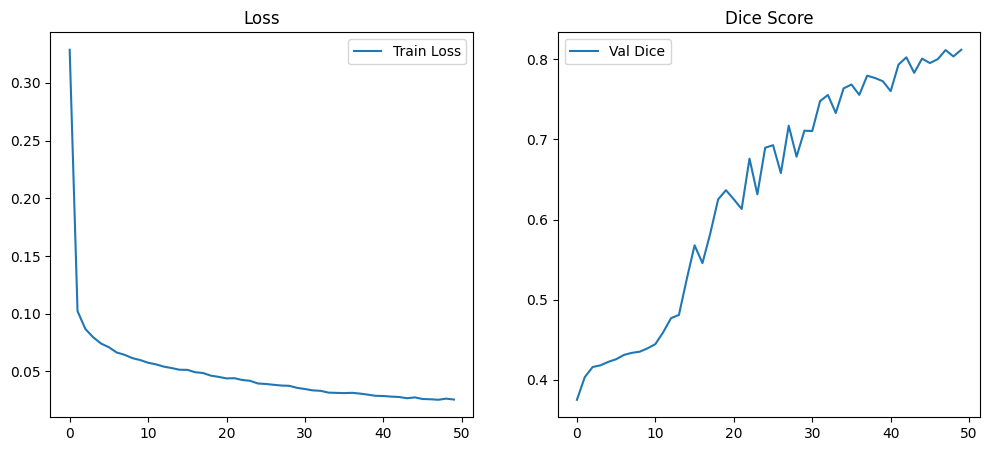

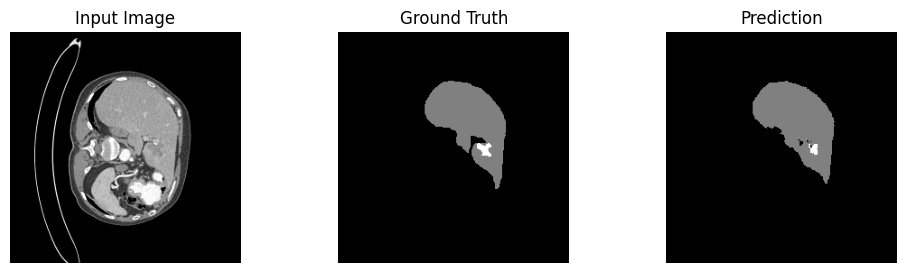

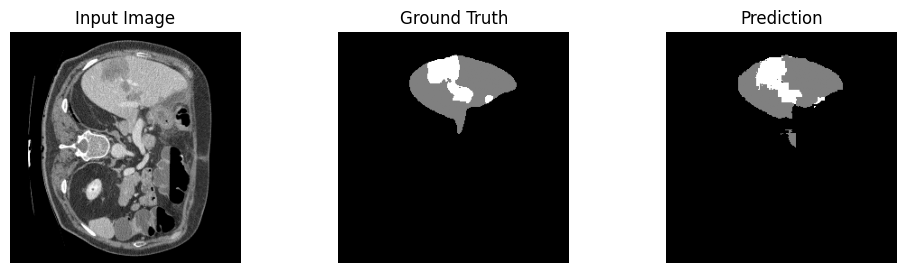

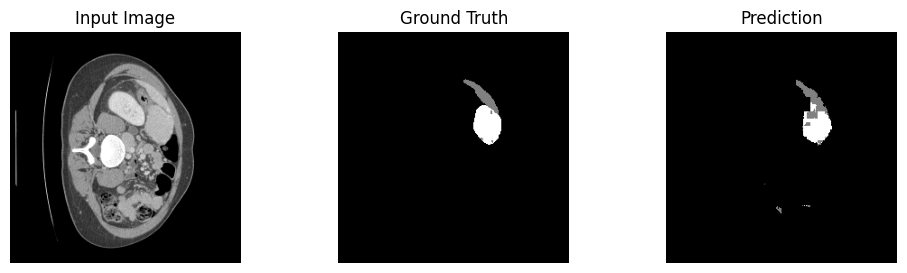

In [12]:
# Training with early stopping and model checkpoint
train_losses, val_dices = [], []
best_dice = 0
patience = 5
counter = 0
save_path = "best_model.pth"

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = ce_loss(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    model.eval()
    dice_total = np.zeros(NUM_CLASSES - 1)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            dice = dice_score(outputs, masks, NUM_CLASSES)
            dice_total += np.array(dice)
    avg_dice = (dice_total / len(val_loader)).mean()
    val_dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Dice: {[round(d, 4) for d in (dice_total / len(val_loader)).tolist()]}")

    # Early stopping
    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved best model (Dice: {best_dice:.4f})")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered")
            break

# Load best model
model.load_state_dict(torch.load(save_path))

# Plot Loss and Dice
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice')
plt.title('Dice Score')
plt.legend()
plt.show()

# Predict on test set
model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1).cpu()

        for j in range(min(3, images.size(0))):  # show 3 predictions
            plt.figure(figsize=(12, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(images[j].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(masks[j].cpu(), cmap='gray')
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[j], cmap='gray')
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
        break